In [10]:
import torch
import numpy as np
import random

def set_all_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(0)

In [11]:
from torchvision.datasets import MNIST

In [12]:
MNIST_train = MNIST(root="./data", train=True, download=True)
MNIST_test = MNIST(root="./data", train=False, download=True)

In [13]:
X_train = MNIST_train.train_data
y_train = MNIST_train.targets
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

print(X_train.shape, y_train.shape, "<- train dataset X and y")
print(X_test.shape, y_test.shape, "<- test dataset X and y")

print(X_train.dtype, y_train.dtype, "<- training data type")

torch.Size([60000, 28, 28]) torch.Size([60000]) <- train dataset X and y
torch.Size([10000, 28, 28]) torch.Size([10000]) <- test dataset X and y
torch.uint8 torch.int64 <- training data type


In [14]:
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

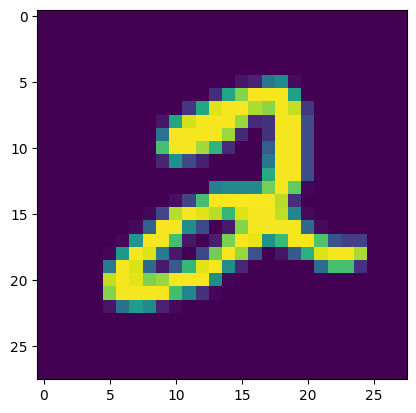

tensor(2.)


In [15]:
import matplotlib.pyplot as plt

index = 5

plt.imshow(X_train[index, :, :])
plt.show()
print(y_train[index])

In [17]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), padding=(2,2))
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), padding=(0,0))
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), padding=(0,0))
        self.act3  = torch.nn.Tanh()
        
        self.flat = torch.nn.Flatten(1, -1)

        self.fc1 = torch.nn.Linear(in_features=120, out_features=84)
        self.act4 = torch.nn.Tanh()

        self.fc2 = torch.nn.Linear(in_features=84, out_features=10)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        
        x = self.flat(x)
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        
        return x
    


In [18]:
lenet5 = LeNet5()

In [19]:
X_test.shape

torch.Size([10000, 28, 28])

In [20]:
X_test.shape

torch.Size([10000, 28, 28])

In [21]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [22]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [23]:
X_test.shape

torch.Size([10000, 1, 28, 28])

In [24]:
lenet5(X_test)

tensor([[-0.0550, -0.0551,  0.0339,  ...,  0.0046,  0.0005,  0.0686],
        [ 0.0117, -0.0563, -0.0023,  ...,  0.0620, -0.0239,  0.0170],
        [ 0.0091, -0.0887,  0.0200,  ...,  0.0417,  0.0288,  0.0640],
        ...,
        [ 0.0079, -0.1448, -0.0396,  ...,  0.0355,  0.0222,  0.0545],
        [ 0.0144, -0.0694,  0.0463,  ...,  0.0297,  0.0236,  0.0387],
        [ 0.0431, -0.1347, -0.0168,  ...,  0.0519,  0.0373,  0.0473]],
       grad_fn=<AddmmBackward0>)

In [25]:
mnist_net = LeNet5()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1e-3)

In [26]:
# Training parameters
batch_size = 100
n_epochs = 30

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []


def model_eval(net, X_test, y_test):
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        test_preds = net(X_test)
        test_loss = loss(test_preds, y_test.long()).item() * X_test.size(0)
        _, predicted = torch.max(test_preds, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

    test_loss /= total
    test_accuracy = correct / total
    return test_loss, test_accuracy


for epoch in range(n_epochs):
    mnist_net.train()
    order = np.random.permutation(len(X_train))
    running_loss = 0.0
    correct = 0
    total = 0

    for start_index in range(0, len(order), batch_size):
        indice = order[start_index : start_index + batch_size]
        X_batch = X_train[indice]
        y_batch = y_train[indice].long()

        batch_preds = mnist_net(X_batch)
        loss_val = loss(batch_preds, y_batch)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        running_loss += loss_val.item() * X_batch.size(0)
        _, predicted = torch.max(batch_preds, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    test_loss, test_accuracy = model_eval(mnist_net, X_test, y_test)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(
        f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

Epoch 1/30, Train Loss: 0.2594, Train Accuracy: 0.9265, Test Loss: 0.0822, Test Accuracy: 0.9746
Epoch 2/30, Train Loss: 0.0720, Train Accuracy: 0.9780, Test Loss: 0.0523, Test Accuracy: 0.9832
Epoch 3/30, Train Loss: 0.0532, Train Accuracy: 0.9836, Test Loss: 0.0530, Test Accuracy: 0.9825
Epoch 4/30, Train Loss: 0.0422, Train Accuracy: 0.9868, Test Loss: 0.0464, Test Accuracy: 0.9854
Epoch 5/30, Train Loss: 0.0351, Train Accuracy: 0.9889, Test Loss: 0.0425, Test Accuracy: 0.9868
Epoch 6/30, Train Loss: 0.0291, Train Accuracy: 0.9910, Test Loss: 0.0412, Test Accuracy: 0.9866
Epoch 7/30, Train Loss: 0.0256, Train Accuracy: 0.9919, Test Loss: 0.0417, Test Accuracy: 0.9861
Epoch 8/30, Train Loss: 0.0226, Train Accuracy: 0.9930, Test Loss: 0.0338, Test Accuracy: 0.9894
Epoch 9/30, Train Loss: 0.0185, Train Accuracy: 0.9938, Test Loss: 0.0390, Test Accuracy: 0.9882
Epoch 10/30, Train Loss: 0.0162, Train Accuracy: 0.9948, Test Loss: 0.0508, Test Accuracy: 0.9839
Epoch 11/30, Train Loss: 0.01

In [27]:
print("Accuracy on test:", model_eval(mnist_net, X_test, y_test)[1])

Accuracy on test: 0.9879


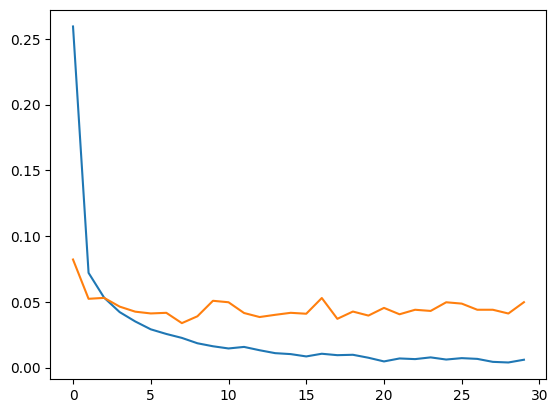

In [28]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)

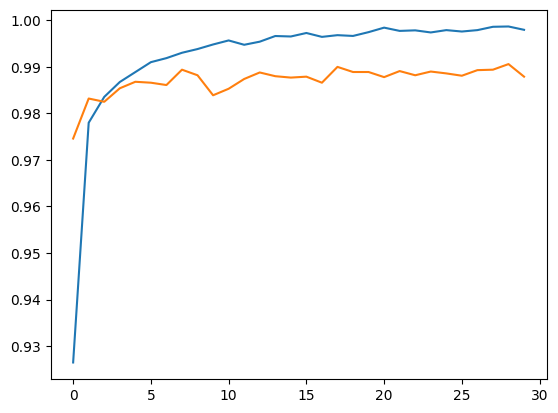

In [29]:
plt.plot(train_accuracy_history)
plt.plot(test_accuracy_history)